# ELTDM Project

# Community Detection with Spark MapReduce

Abstract: blablabla

In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [169]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [170]:
import os
os.getcwd()

'/Users/IjiriYosuke/Documents/ENSAE_MSDS_2018-19/S1/ELTDM/Spark/spark-2.4.0-bin-hadoop2.7/project/ELTDM-Project'

In [171]:
#Read the data
data = np.loadtxt("./Data/test.txt", dtype='uint16')
print(data)
print(type(data))
#data = pd.DataFrame(data)
#data.to_csv("./Data/test_with_index.txt", sep="\t", header=None, index=False)

[[1 2]
 [1 3]
 [2 4]
 [2 5]
 [3 1]
 [3 4]
 [5 3]
 [1 4]
 [8 1]
 [4 8]
 [9 8]
 [7 6]
 [7 8]
 [9 7]
 [9 6]]
<class 'numpy.ndarray'>


In [172]:
#Make a list of adjacency lists (first element is the node of origin)
nodeId = np.unique(data)
nrow = len(data)
adj_list = []

for n in nodeId:
    adj = []
    for i in range(nrow):
        if data[i, 0] == n:
            adj.append(data[i, 1])
        if data[i, 1] == n:
            adj.append(data[i, 0])
    adj = list(set(adj)) 
    adj.insert(0, n)
    adj_list.append(adj)
print(adj_list)

[[1, 8, 2, 3, 4], [2, 1, 4, 5], [3, 1, 4, 5], [4, 8, 1, 2, 3], [5, 2, 3], [6, 9, 7], [7, 8, 9, 6], [8, 1, 4, 9, 7], [9, 8, 6, 7]]


In [173]:
#Make tuple for each node
class tuples():
    def __init__(self, targetId, sourceId, distance, status, weight, pathInfo, adjList) :
        self.targetId = targetId
        self.sourceId = sourceId
        self.distance = distance
        self.status = status
        self.weight = weight
        self.pathInfo = pathInfo
        self.adjList = adjList

network = []
for n in nodeId:
    v = tuples(targetId = n, sourceId = n, distance = 0, status = 'a', weight = 1, pathInfo = [], adjList = [])
    for i in range(len(adj_list)):
        if adj_list[i][0] == n:
            v.adjList = adj_list[i][1:len(adj_list[i])]
            break
    network.append([v.targetId, v.sourceId, v.distance, v.status, v.weight, v.pathInfo, v.adjList])
print(network)

[[1, 1, 0, 'a', 1, [], [8, 2, 3, 4]], [2, 2, 0, 'a', 1, [], [1, 4, 5]], [3, 3, 0, 'a', 1, [], [1, 4, 5]], [4, 4, 0, 'a', 1, [], [8, 1, 2, 3]], [5, 5, 0, 'a', 1, [], [2, 3]], [6, 6, 0, 'a', 1, [], [9, 7]], [7, 7, 0, 'a', 1, [], [8, 9, 6]], [8, 8, 0, 'a', 1, [], [1, 4, 9, 7]], [9, 9, 0, 'a', 1, [], [8, 6, 7]]]


In [174]:
for i in range(len(network)):
    print(network[i])

[1, 1, 0, 'a', 1, [], [8, 2, 3, 4]]
[2, 2, 0, 'a', 1, [], [1, 4, 5]]
[3, 3, 0, 'a', 1, [], [1, 4, 5]]
[4, 4, 0, 'a', 1, [], [8, 1, 2, 3]]
[5, 5, 0, 'a', 1, [], [2, 3]]
[6, 6, 0, 'a', 1, [], [9, 7]]
[7, 7, 0, 'a', 1, [], [8, 9, 6]]
[8, 8, 0, 'a', 1, [], [1, 4, 9, 7]]
[9, 9, 0, 'a', 1, [], [8, 6, 7]]


Parallelization part

In [92]:
sc.stop()
#import findspark 
#findspark.init()
from pyspark import SparkContext, SparkConf
#import copy in order to do deepcopy of tuples
from copy import deepcopy
#from operator import itemgetter
from itertools import groupby
sc = SparkContext()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [175]:
#Set a dataset and create key-value pairs
rdd = sc.parallelize(network)
rdd = rdd.map(lambda x: (x[0], x[1:]))
rdd.collect()

[(1, [1, 0, 'a', 1, [], [8, 2, 3, 4]]),
 (2, [2, 0, 'a', 1, [], [1, 4, 5]]),
 (3, [3, 0, 'a', 1, [], [1, 4, 5]]),
 (4, [4, 0, 'a', 1, [], [8, 1, 2, 3]]),
 (5, [5, 0, 'a', 1, [], [2, 3]]),
 (6, [6, 0, 'a', 1, [], [9, 7]]),
 (7, [7, 0, 'a', 1, [], [8, 9, 6]]),
 (8, [8, 0, 'a', 1, [], [1, 4, 9, 7]]),
 (9, [9, 0, 'a', 1, [], [8, 6, 7]])]

Stage 1 - Map

In [487]:
def stage1_map(p):    
    result = []
    if p[1][2] == 'a':
        p[1][2] = 'i'
        p[1][1] += 1
        p[1][4].append(p[0])
        x = deepcopy(p)
        result.append(x)
        temp = p[1][5].copy()
        for i in range(len(temp)):
            k = temp[i]
            p[1][2] = 'a'
            p[1][5] = []
            y = deepcopy(p)
            result.append((k, y[1]))
    return result
pos_map1 = rdd.flatMap(stage1_map)
pos_map1.collect()
for_testing = pos_map1.collect()
add_for_testing = [(4, [4, 2, 'a', 1, [2], []]), 
    (4, [4, 1, 'a', 1, [3], [1, 3]]),
    (4, [4, 2, 'a', 1, [2], []]),
    (4, [4, 5, 'a', 1, [2], []]),
    (4, [4, 1, 'a', 1, [3], [1, 3]]),
    (4, [4, 1, 'a', 1, [5], [5]]),
    (4, [4, 1, 'a', 1, [2], [2]])]
for_testing.extend(add_for_testing)

for i in range(len(for_testing)):
    print(for_testing[i])
pos_map1_test = sc.parallelize(for_testing)
pos_map1_test.groupByKey().map(lambda x : (x[0], (list(x[1])))).collect()

(1, [1, 1, 'i', 1, [1], [8, 2, 3, 4]])
(8, [1, 1, 'a', 1, [1], []])
(2, [1, 1, 'a', 1, [1], []])
(3, [1, 1, 'a', 1, [1], []])
(4, [1, 1, 'a', 1, [1], []])
(2, [2, 1, 'i', 1, [2], [1, 4, 5]])
(1, [2, 1, 'a', 1, [2], []])
(4, [2, 1, 'a', 1, [2], []])
(5, [2, 1, 'a', 1, [2], []])
(3, [3, 1, 'i', 1, [3], [1, 4, 5]])
(1, [3, 1, 'a', 1, [3], []])
(4, [3, 1, 'a', 1, [3], []])
(5, [3, 1, 'a', 1, [3], []])
(4, [4, 1, 'i', 1, [4], [8, 1, 2, 3]])
(8, [4, 1, 'a', 1, [4], []])
(1, [4, 1, 'a', 1, [4], []])
(2, [4, 1, 'a', 1, [4], []])
(3, [4, 1, 'a', 1, [4], []])
(5, [5, 1, 'i', 1, [5], [2, 3]])
(2, [5, 1, 'a', 1, [5], []])
(3, [5, 1, 'a', 1, [5], []])
(6, [6, 1, 'i', 1, [6], [9, 7]])
(9, [6, 1, 'a', 1, [6], []])
(7, [6, 1, 'a', 1, [6], []])
(7, [7, 1, 'i', 1, [7], [8, 9, 6]])
(8, [7, 1, 'a', 1, [7], []])
(9, [7, 1, 'a', 1, [7], []])
(6, [7, 1, 'a', 1, [7], []])
(8, [8, 1, 'i', 1, [8], [1, 4, 9, 7]])
(1, [8, 1, 'a', 1, [8], []])
(4, [8, 1, 'a', 1, [8], []])
(9, [8, 1, 'a', 1, [8], []])
(7, [8, 1, 'a

[(8,
  [[1, 1, 'a', 1, [1], []],
   [4, 1, 'a', 1, [4], []],
   [7, 1, 'a', 1, [7], []],
   [8, 1, 'i', 1, [8], [1, 4, 9, 7]],
   [9, 1, 'a', 1, [9], []]]),
 (4,
  [[1, 1, 'a', 1, [1], []],
   [2, 1, 'a', 1, [2], []],
   [3, 1, 'a', 1, [3], []],
   [4, 1, 'i', 1, [4], [8, 1, 2, 3]],
   [8, 1, 'a', 1, [8], []],
   [4, 2, 'a', 1, [2], []],
   [4, 1, 'a', 1, [3], [1, 3]],
   [4, 2, 'a', 1, [2], []],
   [4, 5, 'a', 1, [2], []],
   [4, 1, 'a', 1, [3], [1, 3]],
   [4, 1, 'a', 1, [5], [5]],
   [4, 1, 'a', 1, [2], [2]]]),
 (1,
  [[1, 1, 'i', 1, [1], [8, 2, 3, 4]],
   [2, 1, 'a', 1, [2], []],
   [3, 1, 'a', 1, [3], []],
   [4, 1, 'a', 1, [4], []],
   [8, 1, 'a', 1, [8], []]]),
 (5,
  [[2, 1, 'a', 1, [2], []],
   [3, 1, 'a', 1, [3], []],
   [5, 1, 'i', 1, [5], [2, 3]]]),
 (9,
  [[6, 1, 'a', 1, [6], []],
   [7, 1, 'a', 1, [7], []],
   [8, 1, 'a', 1, [8], []],
   [9, 1, 'i', 1, [9], [8, 6, 7]]]),
 (2,
  [[1, 1, 'a', 1, [1], []],
   [2, 1, 'i', 1, [2], [1, 4, 5]],
   [4, 1, 'a', 1, [4], []],
   [5,

In [286]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import SQLContext
#sqlContext = SQLContext(sc)
spark = SparkSession.builder.appName('ELTDM').getOrCreate()
from pyspark.sql import functions as func
from pyspark.sql.functions import count, col
from pyspark.sql.window import Window
from pyspark.sql.functions import struct

from pyspark.sql.types import StructField
from pyspark.sql.types import StructType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StringType
from pyspark.sql.types import ArrayType

In [316]:
fields = [
    StructField('targetId', IntegerType(), False),
    StructField('sourceId', IntegerType(), False),
    StructField('distance', IntegerType(), False),
    StructField('status', StringType(), False), 
    StructField('weight', IntegerType(), False),
    StructField('pathInfo', ArrayType(IntegerType(), True), False), 
    StructField('adjList', ArrayType(IntegerType(), True), False)]
schema = StructType(fields)

temp1 = pos_map1_test.map(lambda x: (int(x[0]),int(x[1][0]),int(x[1][1]),str(x[1][2]),int(x[1][3]),[int(s) for s in x[1][4]],[int(s) for s in x[1][5]])).collect()
temp2 = sc.parallelize(temp1)
df = spark.createDataFrame(temp2, schema)
df.show(100)

print(df.printSchema())
df.registerTempTable("Stage1_pre_reduce")

+--------+--------+--------+------+------+--------+------------+
|targetId|sourceId|distance|status|weight|pathInfo|     adjList|
+--------+--------+--------+------+------+--------+------------+
|       1|       1|       1|     i|     1|     [1]|[8, 2, 3, 4]|
|       8|       1|       1|     a|     1|     [1]|          []|
|       2|       1|       1|     a|     1|     [1]|          []|
|       3|       1|       1|     a|     1|     [1]|          []|
|       4|       1|       1|     a|     1|     [1]|          []|
|       2|       2|       1|     i|     1|     [2]|   [1, 4, 5]|
|       1|       2|       1|     a|     1|     [2]|          []|
|       4|       2|       1|     a|     1|     [2]|          []|
|       5|       2|       1|     a|     1|     [2]|          []|
|       3|       3|       1|     i|     1|     [3]|   [1, 4, 5]|
|       1|       3|       1|     a|     1|     [3]|          []|
|       4|       3|       1|     a|     1|     [3]|          []|
|       5|       3|      

In [381]:
q = """
SELECT
  targetId,
  sourceId,
  distance,
  status,
  weight,
  pathInfo,
  adjList
FROM
  Stage1_pre_reduce
ORDER BY targetId, sourceId
"""
df_ = sqlContext.sql(q)
df_.registerTempTable("Sorted")
df_.show()

+--------+--------+--------+------+------+--------+------------+
|targetId|sourceId|distance|status|weight|pathInfo|     adjList|
+--------+--------+--------+------+------+--------+------------+
|       1|       1|       1|     i|     1|     [1]|[8, 2, 3, 4]|
|       1|       2|       1|     a|     1|     [2]|          []|
|       1|       3|       1|     a|     1|     [3]|          []|
|       1|       4|       1|     a|     1|     [4]|          []|
|       1|       8|       1|     a|     1|     [8]|          []|
|       2|       1|       1|     a|     1|     [1]|          []|
|       2|       2|       1|     i|     1|     [2]|   [1, 4, 5]|
|       2|       4|       1|     a|     1|     [4]|          []|
|       2|       5|       1|     a|     1|     [5]|          []|
|       3|       1|       1|     a|     1|     [1]|          []|
|       3|       3|       1|     i|     1|     [3]|   [1, 4, 5]|
|       3|       4|       1|     a|     1|     [4]|          []|
|       3|       5|      

In [ ]:
q = """
SELECT
 tableA.targetId,
 tableA.sourceId,
 tableA.distance
FROM
 Sorted AS tableA
INNER JOIN (SELECT targetId,sourceId,MIN(distance) AS MinDis FROM Sorted GROUP BY sourceId) AS tableB
ON tableA.targetId = tableB.targetId 
WHERE tableA.distance = tableB.MinDis
"""
sqlContext.sql(q).show(100)

In [317]:
q = """
SELECT
  targetId,
  sourceId,
  distance,
  MIN(distance) OVER (PARTITION BY sourceId ORDER BY targetId) as min_distance,
  status,
  weight,
  pathInfo,
  adjList
FROM
  Stage1_pre_reduce
"""
sqlContext.sql(q).show(100)

+--------+--------+--------+------------+------+------+--------+------------+
|targetId|sourceId|distance|min_distance|status|weight|pathInfo|     adjList|
+--------+--------+--------+------------+------+------+--------+------------+
|       1|       1|       1|           1|     i|     1|     [1]|[8, 2, 3, 4]|
|       2|       1|       1|           1|     a|     1|     [1]|          []|
|       3|       1|       1|           1|     a|     1|     [1]|          []|
|       4|       1|       1|           1|     a|     1|     [1]|          []|
|       8|       1|       1|           1|     a|     1|     [1]|          []|
|       6|       6|       1|           1|     i|     1|     [6]|      [9, 7]|
|       7|       6|       1|           1|     a|     1|     [6]|          []|
|       9|       6|       1|           1|     a|     1|     [6]|          []|
|       1|       3|       1|           1|     a|     1|     [3]|          []|
|       3|       3|       1|           1|     i|     1|     [3]|

Stage 1 - Reduce

In [520]:
pos_map1_test.collect()
red1_twokeys = pos_map1_test.map(lambda x: ((x[0],x[1][0]), x[1][1:]))
red1_twokeys.collect()

[((1, 1), [1, 'i', 1, [1], [8, 2, 3, 4]]),
 ((8, 1), [1, 'a', 1, [1], []]),
 ((2, 1), [1, 'a', 1, [1], []]),
 ((3, 1), [1, 'a', 1, [1], []]),
 ((4, 1), [1, 'a', 1, [1], []]),
 ((2, 2), [1, 'i', 1, [2], [1, 4, 5]]),
 ((1, 2), [1, 'a', 1, [2], []]),
 ((4, 2), [1, 'a', 1, [2], []]),
 ((5, 2), [1, 'a', 1, [2], []]),
 ((3, 3), [1, 'i', 1, [3], [1, 4, 5]]),
 ((1, 3), [1, 'a', 1, [3], []]),
 ((4, 3), [1, 'a', 1, [3], []]),
 ((5, 3), [1, 'a', 1, [3], []]),
 ((4, 4), [1, 'i', 1, [4], [8, 1, 2, 3]]),
 ((8, 4), [1, 'a', 1, [4], []]),
 ((1, 4), [1, 'a', 1, [4], []]),
 ((2, 4), [1, 'a', 1, [4], []]),
 ((3, 4), [1, 'a', 1, [4], []]),
 ((5, 5), [1, 'i', 1, [5], [2, 3]]),
 ((2, 5), [1, 'a', 1, [5], []]),
 ((3, 5), [1, 'a', 1, [5], []]),
 ((6, 6), [1, 'i', 1, [6], [9, 7]]),
 ((9, 6), [1, 'a', 1, [6], []]),
 ((7, 6), [1, 'a', 1, [6], []]),
 ((7, 7), [1, 'i', 1, [7], [8, 9, 6]]),
 ((8, 7), [1, 'a', 1, [7], []]),
 ((9, 7), [1, 'a', 1, [7], []]),
 ((6, 7), [1, 'a', 1, [7], []]),
 ((8, 8), [1, 'i', 1, [8], 

In [542]:
def join(x, y):
    if (type(x[0]) is list) and (type(y[0]) is not list):
        return x+[y]
    elif (type(x[0]) is not list) and (type(y[0]) is list):
        return [x]+y
    elif (type(x[0]) is not list) and (type(y[0]) is not list):
        return [x]+[y]
    else:
        return x+y
    isinstance(x[0], int)
red1_grouped = red1_twokeys.reduceByKey(join)
red1_twokeys.reduceByKey(join).collect()

[((1, 1), [1, 'i', 1, [1], [8, 2, 3, 4]]),
 ((4, 2), [1, 'a', 1, [2], []]),
 ((3, 3), [1, 'i', 1, [3], [1, 4, 5]]),
 ((2, 4), [1, 'a', 1, [4], []]),
 ((5, 5), [1, 'i', 1, [5], [2, 3]]),
 ((7, 7), [1, 'i', 1, [7], [8, 9, 6]]),
 ((9, 9), [1, 'i', 1, [9], [8, 6, 7]]),
 ((8, 1), [1, 'a', 1, [1], []]),
 ((4, 1), [1, 'a', 1, [1], []]),
 ((1, 2), [1, 'a', 1, [2], []]),
 ((5, 2), [1, 'a', 1, [2], []]),
 ((3, 4), [1, 'a', 1, [4], []]),
 ((9, 6), [1, 'a', 1, [6], []]),
 ((6, 7), [1, 'a', 1, [7], []]),
 ((7, 8), [1, 'a', 1, [8], []]),
 ((8, 9), [1, 'a', 1, [9], []]),
 ((3, 1), [1, 'a', 1, [1], []]),
 ((2, 2), [1, 'i', 1, [2], [1, 4, 5]]),
 ((1, 3), [1, 'a', 1, [3], []]),
 ((5, 3), [1, 'a', 1, [3], []]),
 ((4, 4),
  [[1, 'i', 1, [4], [8, 1, 2, 3]],
   [2, 'a', 1, [2], []],
   [1, 'a', 1, [3], [1, 3]],
   [2, 'a', 1, [2], []],
   [5, 'a', 1, [2], []],
   [1, 'a', 1, [3], [1, 3]],
   [1, 'a', 1, [5], [5]],
   [1, 'a', 1, [2], [2]]]),
 ((8, 4), [1, 'a', 1, [4], []]),
 ((3, 5), [1, 'a', 1, [5], []]),


In [640]:
def Stage1_reduce(x):
    if type(x[1][0]) is list:
        m = x[1][0][0]
        for s in range(len(x[1])):
            if x[1][s][0] < m:
                m = x[1][s][0]
        minList = []
        #Drop tuple(s) with non-shortest distance
        for s in range(len(x[1])):
            if x[1][s][0] == m:
                minList.append(x[1][s])
        y = (x[0], minList)
        #Update weight
        for s in range(len(minList)):
            y[1][s][2] = len(minList)
        return y
    else:
        return x
red1_weighted = red1_grouped.map(Stage1_reduce)
red1_grouped.map(delbig).collect()

[((1, 1), [1, 'i', 1, [1], [8, 2, 3, 4]]),
 ((4, 2), [1, 'a', 1, [2], []]),
 ((3, 3), [1, 'i', 1, [3], [1, 4, 5]]),
 ((2, 4), [1, 'a', 1, [4], []]),
 ((5, 5), [1, 'i', 1, [5], [2, 3]]),
 ((7, 7), [1, 'i', 1, [7], [8, 9, 6]]),
 ((9, 9), [1, 'i', 1, [9], [8, 6, 7]]),
 ((8, 1), [1, 'a', 1, [1], []]),
 ((4, 1), [1, 'a', 1, [1], []]),
 ((1, 2), [1, 'a', 1, [2], []]),
 ((5, 2), [1, 'a', 1, [2], []]),
 ((3, 4), [1, 'a', 1, [4], []]),
 ((9, 6), [1, 'a', 1, [6], []]),
 ((6, 7), [1, 'a', 1, [7], []]),
 ((7, 8), [1, 'a', 1, [8], []]),
 ((8, 9), [1, 'a', 1, [9], []]),
 ((3, 1), [1, 'a', 1, [1], []]),
 ((2, 2), [1, 'i', 1, [2], [1, 4, 5]]),
 ((1, 3), [1, 'a', 1, [3], []]),
 ((5, 3), [1, 'a', 1, [3], []]),
 ((4, 4),
  [[1, 'i', 5, [4], [8, 1, 2, 3]],
   [1, 'a', 5, [3], [1, 3]],
   [1, 'a', 5, [3], [1, 3]],
   [1, 'a', 5, [5], [5]],
   [1, 'a', 5, [2], [2]]]),
 ((8, 4), [1, 'a', 1, [4], []]),
 ((3, 5), [1, 'a', 1, [5], []]),
 ((6, 6), [1, 'i', 1, [6], [9, 7]]),
 ((9, 7), [1, 'a', 1, [7], []]),
 ((8,

In [643]:
def twokeys_to_onekey(x):
    k = x[0][0]
    v = [x[0][1]]
    v.extend(x[1])
    return k, v
#From two-keys tuples to one-key tuples
record = red1_weighted.map(twokeys_to_onekey).collect()

#To flatten the grouped values (non-parallelized)
new = []
for i in range(len(record)):
    if type(record[i][1][1]) is list:
        record[i]
        key = record[i][0]
        srcId = [record[i][1][0]]
        others = record[i][1][1:]
        for j in range(len(others)):
            s = srcId.copy()
            o = others[j]
            s.extend(o)
            newrec = (key, s)
            new.append(newrec)
pos_red1 = list(filter(lambda item: type(item[1][1]) != list, record))  
pos_red1.extend(new)
for i in range(len(pos_red1)):
    print(pos_red1[i])

(1, [1, 1, 'i', 1, [1], [8, 2, 3, 4]])
(4, [2, 1, 'a', 1, [2], []])
(3, [3, 1, 'i', 1, [3], [1, 4, 5]])
(2, [4, 1, 'a', 1, [4], []])
(5, [5, 1, 'i', 1, [5], [2, 3]])
(7, [7, 1, 'i', 1, [7], [8, 9, 6]])
(9, [9, 1, 'i', 1, [9], [8, 6, 7]])
(8, [1, 1, 'a', 1, [1], []])
(4, [1, 1, 'a', 1, [1], []])
(1, [2, 1, 'a', 1, [2], []])
(5, [2, 1, 'a', 1, [2], []])
(3, [4, 1, 'a', 1, [4], []])
(9, [6, 1, 'a', 1, [6], []])
(6, [7, 1, 'a', 1, [7], []])
(7, [8, 1, 'a', 1, [8], []])
(8, [9, 1, 'a', 1, [9], []])
(3, [1, 1, 'a', 1, [1], []])
(2, [2, 1, 'i', 1, [2], [1, 4, 5]])
(1, [3, 1, 'a', 1, [3], []])
(5, [3, 1, 'a', 1, [3], []])
(8, [4, 1, 'a', 1, [4], []])
(3, [5, 1, 'a', 1, [5], []])
(6, [6, 1, 'i', 1, [6], [9, 7]])
(9, [7, 1, 'a', 1, [7], []])
(8, [8, 1, 'i', 1, [8], [1, 4, 9, 7]])
(4, [8, 1, 'a', 1, [8], []])
(7, [9, 1, 'a', 1, [9], []])
(2, [1, 1, 'a', 1, [1], []])
(4, [3, 1, 'a', 1, [3], []])
(1, [4, 1, 'a', 1, [4], []])
(2, [5, 1, 'a', 1, [5], []])
(7, [6, 1, 'a', 1, [6], []])
(8, [7, 1, 'a', 

In [495]:
#re_red1 = pos_map1.groupByKey().map(lambda x : (x[0], (list(x[1])))).collect()
#pre_red1 = sc.parallelize(pre_red1)
def join(x, y):
    if (type(x[0]) is list) and (type(y[0]) is not list):
        return x+[y]
    elif (type(x[0]) is not list) and (type(y[0]) is list):
        return [x]+y
    elif (type(x[0]) is not list) and (type(y[0]) is not list):
        return [x]+[y]
    else:
        return x+y
    isinstance(x[0], int)
pos_map1_test.reduceByKey(join).collect()

#reduced = pos_map1_test.reduceByKey(lambda x, y: (x,y))

#reduced.flatMap(lambda x: x).collect()

#def stage1_reduce(p):
#    if 
#
#pos_red1 = pre_red1.reduce(stage1_reduce)
#pos_red1.collect()

[(8,
  [[1, 1, 'a', 1, [1], []],
   [4, 1, 'a', 1, [4], []],
   [7, 1, 'a', 1, [7], []],
   [8, 1, 'i', 1, [8], [1, 4, 9, 7]],
   [9, 1, 'a', 1, [9], []]]),
 (4,
  [[1, 1, 'a', 1, [1], []],
   [2, 1, 'a', 1, [2], []],
   [3, 1, 'a', 1, [3], []],
   [4, 1, 'i', 1, [4], [8, 1, 2, 3]],
   [8, 1, 'a', 1, [8], []],
   [4, 2, 'a', 1, [2], []],
   [4, 1, 'a', 1, [3], [1, 3]],
   [4, 2, 'a', 1, [2], []],
   [4, 5, 'a', 1, [2], []],
   [4, 1, 'a', 1, [3], [1, 3]],
   [4, 1, 'a', 1, [5], [5]],
   [4, 1, 'a', 1, [2], [2]]]),
 (1,
  [[1, 1, 'i', 1, [1], [8, 2, 3, 4]],
   [2, 1, 'a', 1, [2], []],
   [3, 1, 'a', 1, [3], []],
   [4, 1, 'a', 1, [4], []],
   [8, 1, 'a', 1, [8], []]]),
 (5,
  [[2, 1, 'a', 1, [2], []],
   [3, 1, 'a', 1, [3], []],
   [5, 1, 'i', 1, [5], [2, 3]]]),
 (9,
  [[6, 1, 'a', 1, [6], []],
   [7, 1, 'a', 1, [7], []],
   [8, 1, 'a', 1, [8], []],
   [9, 1, 'i', 1, [9], [8, 6, 7]]]),
 (2,
  [[1, 1, 'a', 1, [1], []],
   [2, 1, 'i', 1, [2], [1, 4, 5]],
   [4, 1, 'a', 1, [4], []],
   [5,

Visualisation Part

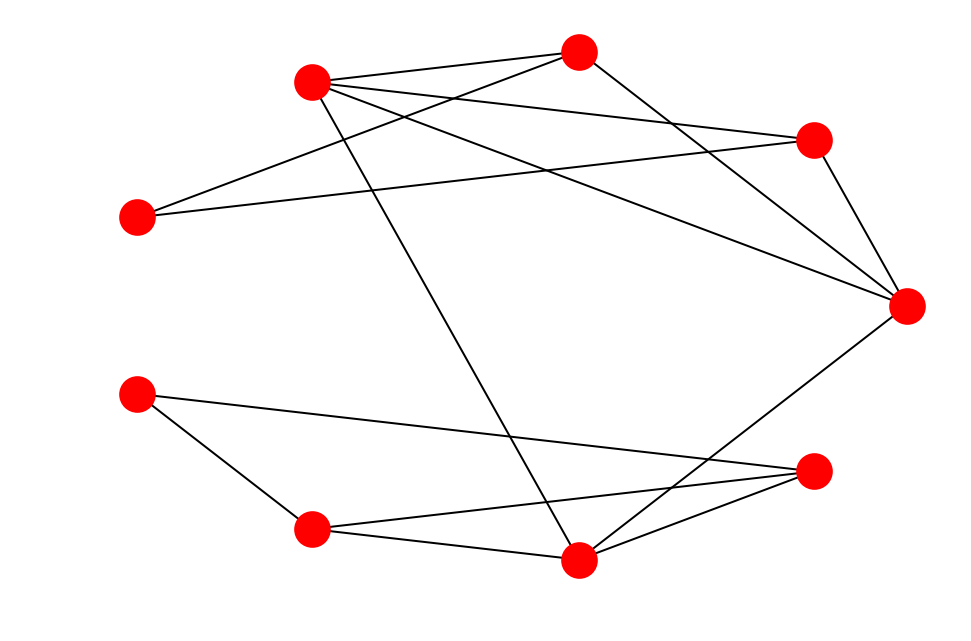

In [178]:
#Visualisation of the graph
#This is just for reference for now
import pandas
import networkx as nx
import matplotlib.pyplot as plt

def draw_graph(graph):

    # extract nodes from graph
    nodes = set([n1 for n1, n2 in graph] + [n2 for n1, n2 in graph])

    # create networkx graph
    G=nx.Graph()

    # add nodes
    for node in nodes:
        G.add_node(node)

    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])

    # draw graph
    pos = nx.shell_layout(G)
    nx.draw(G, pos)

    # show graph
    plt.show()
    
draw_graph(data)
